# Rating Predictions on Yelp dataset

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


# Installations and imports:

In [0]:
!pip install spacy
!pip install contractions
!pip install spacy-langdetect

Change working directory

In [0]:
%cd /content/gdrive/My Drive/yelp

/content/gdrive/My Drive/yelp


GloVe embeddings

In [0]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

In [0]:
!unzip glove.twitter.27B.zip.2

Imports:

In [0]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import string
import gc
import contractions
import spacy.cli,spacy

In [0]:
spacy.cli.download("en")
spacy.load('en_core_web_sm')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


# Load dataset:
**1] get file from  drive:**

Read file:

In [0]:
df = pd.read_csv("yelp_review.csv",usecols=['text','useful','stars'])

df.shape

(5261668, 3)

In [0]:
df.head()

,stars,text,useful
0,5,Super simple place but amazing nonetheless. It...,0
1,5,Small unassuming place that changes their menu...,0
2,5,Lester's is located in a beautiful neighborhoo...,0
3,4,Love coming here. Yes the place always needs t...,0
4,4,Had their chocolate almond croissant and it wa...,0


Drop reveiws that are not labelled as useful

In [0]:
df = df.query('useful > 0')

In [0]:
del df['useful']

In [0]:
print(df.shape)

(2517186, 2)


Bar chart of frequencies:

stars
1    429215
2    241501
3    303124
4    586891
5    956455
dtype: int64


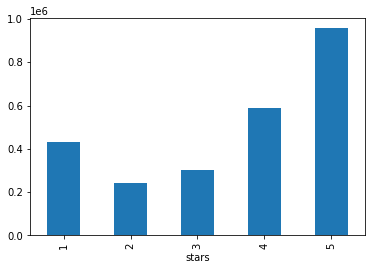

In [0]:
df.groupby('stars').size().plot.bar()
print(df.groupby('stars').size())


Balance data:

In [0]:
#balance dataset
df = df.groupby('stars', as_index=False).apply(lambda x: x.sample(n=241501)).reset_index(drop=True)



In [0]:
df=df.drop_duplicates(subset='text')
df=df.dropna()

In [0]:
df.shape

(1207191, 2)

Drop some rows for a smaller dataset:

In [0]:
#drop some rows for a smaller datset
remove_n=int(round(df.shape[0]*0.5))  #remove 30%
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df= df.drop(drop_indices).reset_index(drop=True)
df.shape

(603595, 2)

shuffle dataset

In [0]:
df = df.sample(frac=1).reset_index(drop=True)

In [0]:
gc.collect()

2526

# Prepare text for processing:

In [0]:
from tqdm import tqdm #progress for pandas
tqdm.pandas()
from spacy_langdetect import LanguageDetector


In [0]:
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)
nlp.vocab["not"].is_stop = False
nlp.vocab["no"].is_stop = False

In [0]:
def preProcess(doc):
    #expand contractions:
    doc=contractions.fix(doc)

    doc = nlp(doc)
    #make text lowercase
    #remove punctuation
    #remove special characters and stop words
    tokens = [ token.lemma_.lower().strip() for token in doc
              if not token.is_stop and not token.is_punct and
              not token.is_space and token.is_alpha]    
    return " ".join(tokens)

In [0]:
def multiPreProcess(token):
   if token.is_alpha and not token.is_stop and not token.is_punct and not token.is_space:
        return True
   return False
    

In [0]:
df['text']=df['text'].progress_apply(lambda text: contractions.fix(text))

100%|██████████| 603595/603595 [00:31<00:00, 19069.97it/s]


In [0]:
docs = df['text'].tolist()

In [0]:
cleanText = []
lang = []
for doc in tqdm(nlp.pipe(docs,disable=["tagger", "ner"])):
    lang.append(doc._.language)
    tokens = [token.lemma_.lower().strip() for token in doc if multiPreProcess(token)]
    cleanText.append(" ".join(tokens))

603595it [2:18:29, 72.64it/s] 


In [0]:
language = [d.get('language') for d in lang]

In [0]:
df=pd.DataFrame({'text':df['text'],'clean':cleanText, 'stars':df['stars'],'lang':language})

In [0]:
df = df.drop(df[df.lang != 'en'].index)

In [0]:
del df['lang']

In [0]:
gc.collect()

122

In [0]:
df.to_pickle('PreprocessedEnglishYelp3.pkl')

# Load clean data:

In [0]:
import pickle as pkl

In [0]:
df = pd.read_pickle('PreprocessedEnglishYelp3.pkl')

In [0]:
test = pd.read_pickle('test1.pkl')
train = pd.read_pickle('train1.pkl')

In [0]:
df.shape

(166594, 4)

In [0]:
with open('YelpBalancedTokenizer2.pkl', 'rb') as handle:
    tokenizer = pkl.load(handle)

# Vectorization

load GloVe embeddings

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


Using TensorFlow backend.


In [0]:
embeddings_dict = {}
with open("glove.twitter.27B.200d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

**Split data:**

In [0]:
train, test = train_test_split(df, test_size=0.2,random_state=112)

In [0]:
embed_size = 200 #embedding size
max_features = 30000 #unique words
maxlen = 250 #per review

In [0]:
tokenizer=Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train['text'].values))

Save tokenizer 

In [0]:
with open('finalAttempt3.pkl', 'wb') as handle:
    pkl.dump(tokenizer, handle, protocol=pkl.HIGHEST_PROTOCOL)

In [0]:
x_train=tokenizer.texts_to_sequences(list(train['text'].values))
x_test=tokenizer.texts_to_sequences(list(test['text'].values))
x_train=pad_sequences(x_train, maxlen=maxlen)
x_test=pad_sequences(x_test,maxlen=maxlen)

One-hot encode the stars:

In [0]:
y_train = np.array(pd.get_dummies( train['stars']))
y_test = np.array(pd.get_dummies(test['stars']))

In [0]:
y_train=np.array(train['stars'].values)
y_test=np.array(test['stars'].values)

In [0]:
word_index = tokenizer.word_index

embedding_matrix = np.zeros((max_features, embed_size))
for word, index in word_index.items():
    if index > max_features-1:
        continue
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

#Build Models:

# LSTM GRU
from: https://www.kaggle.com/athoul01/predicting-yelp-ratings-from-review-text

imports:

In [0]:
gc.collect()

275

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input,Conv1D, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU
from tensorflow.keras.layers import BatchNormalization,Bidirectional,MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.layers import CuDNNLSTM, CuDNNGRU,Flatten, Attention
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1L2
import tensorflow

In [0]:
import tensorflow.keras.backend as K

def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [0]:
inp = Input(shape = (maxlen,))
x = Embedding(max_features, embed_size, weights = [embedding_matrix], trainable = False)(inp)
#x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)#, kernel_regularizer=L1L2(l1=0.0001,l2=0.0001), recurrent_regularizer=L1L2(l1=0.0001,l2=0.0001)))(x)
x = Bidirectional(GRU(64, return_sequences=True))(x)#,kernel_regularizer=L1L2(l1=0.0001,l2=0.0001), recurrent_regularizer=L1L2(l1=0.0001,l2=0.0001)))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
conc = Dropout(0.2)(conc)
conc = Dense (20)(conc)
conc = Dropout(0.2)(conc)
outp = Dense(5, activation = 'softmax')(conc)
model = Model(inputs = inp, outputs = outp)
# patience is how many epochs to wait to see if val_loss will improve again.
earlystop = EarlyStopping(monitor = 'val_loss', patience = 6)
model.compile(loss = 'categorical_crossentropy', optimizer = 'Nadam', metrics=['acc'])

In [0]:
model.load_weights('multiclass.h5')

In [0]:
model.save('finalModel.h5')

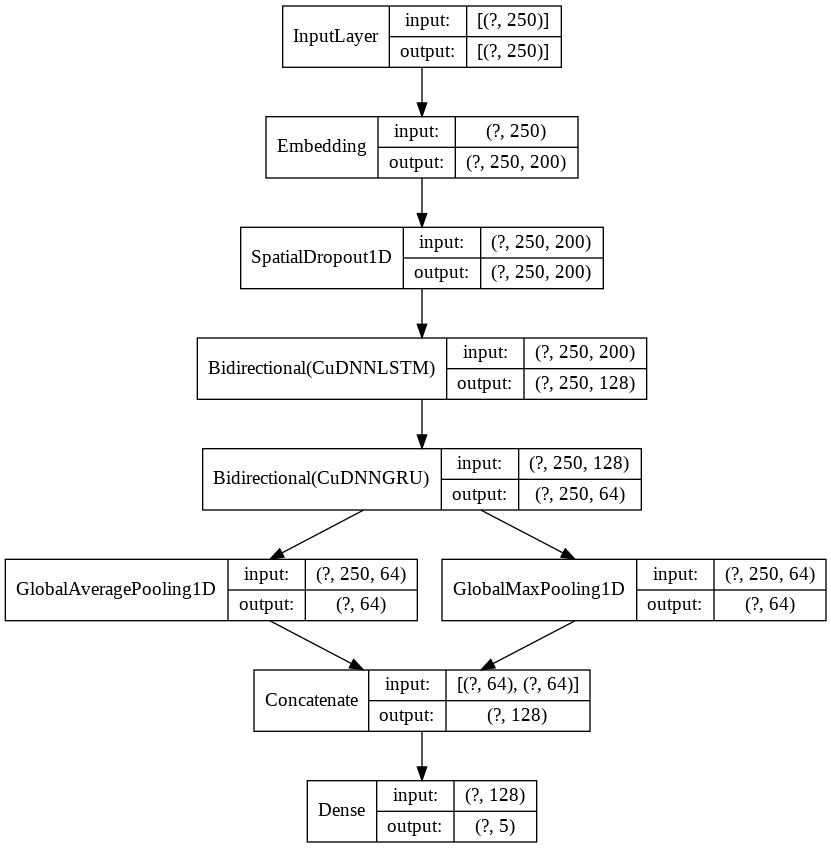

In [0]:
tensorflow.keras.utils.plot_model(
    model,
    to_file="LSTMGRU.png",
    show_shapes=True,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [0]:
gc.collect()

41953

In [0]:
history=model.fit(x_train, y_train,initial_epoch=0 ,batch_size = 2000, shuffle=True, epochs = 50, validation_split = .2,callbacks=[earlystop])

In [0]:
accuracy=[]
val_acc=[]
loss=[]
val_loss=[]

In [0]:
accuracy.extend(history.history['acc'] )
loss.extend(history.history['loss'] )
val_acc.extend(history.history['val_acc'] )
val_loss.extend(history.history['val_loss'] )

In [0]:
import matplotlib.pyplot as plt
plt.title('Training Curve')
plt.xlabel('Epoch')
plt.plot(accuracy)
plt.plot(val_acc)

plt.legend(['accuracy','val_accuracy'], loc='upper left')


plt.show()

In [0]:
plt.title('Training Curve')
plt.xlabel('Epoch')
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss','val_loss'], loc='upper left')


plt.show()

In [0]:
model.evaluate(x_test, y_test, verbose = 1, batch_size=1024)

In [0]:
predictions = model.predict(x_test, verbose = 1)

In [0]:
preds=[]
for p in (predictions):
  preds.append(np.argmax(p)+1)

In [0]:
from sklearn.metrics import classification_report

print(classification_report(preds,test['stars']))

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


true=np.array(test['stars'].values)

cf_matrix = confusion_matrix(true,preds)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',xticklabels=['1','2','3','4','5'],yticklabels=['1','2','3','4','5'])
plt.show()


# CNN with LSTM: 

from: https://medium.com/@mrunal68/text-sentiments-classification-with-cnn-and-lstm-f92652bc29fd

In [0]:
from tensorflow.keras.optimizers import Nadam,Adamax,Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(Embedding(max_features, embed_size,weights = [embedding_matrix],input_length=maxlen, trainable = False))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.5))
model.add(Bidirectional(CuDNNLSTM(128)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse',
              optimizer='Nadam',
              metrics=[soft_acc])
print(model.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=6)]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 250, 200)          6000000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 246, 64)           64064     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 61, 64)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 61, 64)            0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 256)               198656    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [0]:
model= tensorflow.keras.models.load_model('cnnlstm.h5')

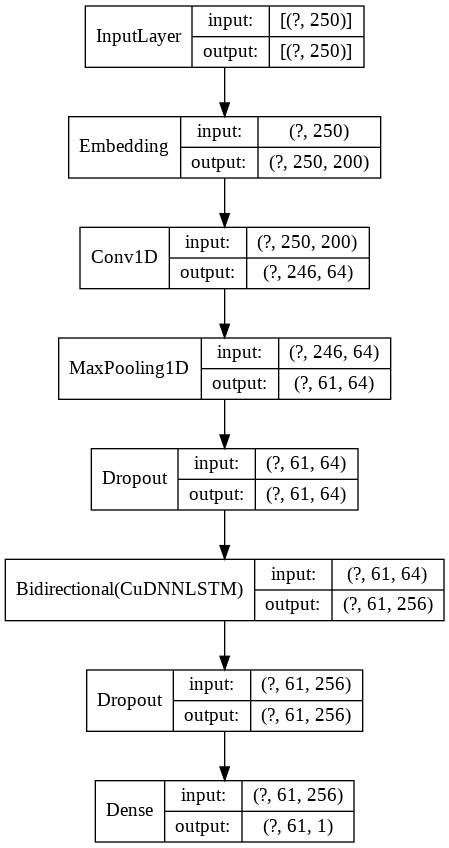

In [0]:
tensorflow.keras.utils.plot_model(
    model,
    to_file="LSTMGRU.png",
    show_shapes=True,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [0]:
gc.collect()

11225

In [0]:
history=model.fit(x_train, y_train,initial_epoch=0, epochs=50, shuffle=True, batch_size=1500,verbose = 1,callbacks = callbacks,validation_split = .3)

Epoch 1/50
224/224 [==============================] - 30s 133ms/step - loss: 1.3361 - soft_acc: 0.3482 - val_loss: 0.8779 - val_soft_acc: 0.4226
Epoch 2/50
224/224 [==============================] - 30s 132ms/step - loss: 0.8729 - soft_acc: 0.4312 - val_loss: 0.7160 - val_soft_acc: 0.4816
Epoch 3/50
224/224 [==============================] - 29s 131ms/step - loss: 0.7901 - soft_acc: 0.4596 - val_loss: 0.6713 - val_soft_acc: 0.4961
Epoch 4/50
224/224 [==============================] - 29s 131ms/step - loss: 0.7479 - soft_acc: 0.4740 - val_loss: 0.6460 - val_soft_acc: 0.5077
Epoch 5/50
224/224 [==============================] - 30s 133ms/step - loss: 0.7189 - soft_acc: 0.4833 - val_loss: 0.6448 - val_soft_acc: 0.5101
Epoch 6/50
224/224 [==============================] - 29s 131ms/step - loss: 0.6961 - soft_acc: 0.4917 - val_loss: 0.6311 - val_soft_acc: 0.5068
Epoch 7/50
224/224 [==============================] - 29s 131ms/step - loss: 0.6766 - soft_acc: 0.4991 - val_loss: 0.6048 - val_so

In [0]:
print(train.shape)
print(test.shape)

(479528, 3)
(119882, 3)


In [0]:
model.save('cnnlstm.h5')

In [0]:
predictions = model.predict(x_test, verbose = 1)

3747/3747 [==============================] - 19s 5ms/step


In [0]:
preds=[]
for p in (predictions):
  preds.append(np.argmax(p)+1)

In [0]:
preds=np.rint(predictions).astype(int)

In [0]:
from sklearn.metrics import classification_report

print(classification_report(preds,test['stars']))

              precision    recall  f1-score   support

           1       0.64      0.78      0.71     19783
           2       0.55      0.49      0.52     26817
           3       0.53      0.47      0.49     27319
           4       0.57      0.47      0.52     28880
           5       0.55      0.78      0.64     17083

    accuracy                           0.57    119882
   macro avg       0.57      0.60      0.58    119882
weighted avg       0.57      0.57      0.56    119882



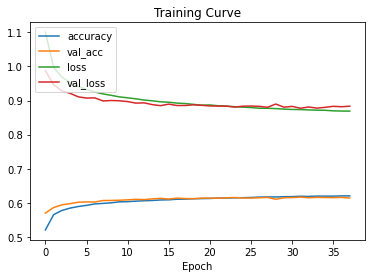

In [0]:
import matplotlib.pyplot as plt
plt.title('Training Curve')
plt.xlabel('Epoch')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['accuracy','val_acc', 'loss','val_loss'], loc='upper left')


plt.show()

In [0]:
model.evaluate(x_test, y_test, verbose = 1, batch_size=1024)

206/206 [==============================] - 19s 93ms/step - loss: 0.8852 - accuracy: 0.6154


[0.8851678967475891, 0.6154095530509949]

In [0]:
model.save('yelpUnbalancedLSTM_CNN.h5')
!cp yelpUnbalancedLSTM_CNN.h5 '/content/gdrive/''My Drive''/'

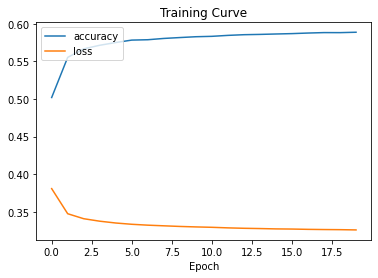

In [0]:
import matplotlib.pyplot as plt
plt.title('Training Curve')
plt.xlabel('Epoch')
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['accuracy', 'loss'], loc='upper left')


plt.show()

In [0]:
model.evaluate([x_test,x_test,x_test], y_test, verbose = 1, batch_size=1024)

428/428 [==============================] - 14s 32ms/step - loss: 0.3232 - accuracy: 0.5946


[0.32320526242256165, 0.5945965051651001]

In [0]:
model.save('yelpCNN2.h5')
!cp yelpCNN2.h5 '/content/gdrive/''My Drive''/'

# SVM

In [0]:
train, test = train_test_split(df, test_size=0.2,random_state=112)

In [0]:
y_train=np.array(train['stars'].values)
y_test=np.array(test['stars'].values)

In [0]:
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
tfidf = TfidfVectorizer(max_features=30000,ngram_range=(1,1))
tfidf.fit(list(train['text'].values))
x_train=tfidf.transform(list(train['text'].values))
x_test=tfidf.transform(list(test['text'].values))
x_train.shape

In [0]:
#save model
import pickle
pickle.dump(tfidf, open("tfidf1.pkl", "wb"))


In [0]:
print(tfidf.get_feature_names())

In [0]:
svc_model = LinearSVC(multi_class='ovr', verbose=1000,  max_iter=50000)
svc_model.fit(x_train,y_train)
prediction= svc_model.predict(x_test)
print("SVM done training")


[LibLinear]SVM done training


In [0]:
from sklearn.metrics import classification_report

print(classification_report( y_test, prediction))

              precision    recall  f1-score   support

           1       0.62      0.66      0.64      6641
           2       0.43      0.41      0.42      6612
           3       0.42      0.39      0.40      6719
           4       0.43      0.43      0.43      6581
           5       0.60      0.64      0.62      6766

    accuracy                           0.51     33319
   macro avg       0.50      0.51      0.50     33319
weighted avg       0.50      0.51      0.50     33319



In [0]:
#save model
import pickle
filename = 'neutralSVM.sav'
pickle.dump(svc_model, open(filename, 'wb'))
print("SVM done saving")

SVM done saving


# Logistic Regression

In [0]:
clf = LogisticRegression(random_state=0,verbose=100,multi_class='multinomial',solver='newton-cg')
model=clf.fit(x_train,y_train)
prediction= clf.predict(x_test)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.8s finished


In [0]:
from sklearn.metrics import classification_report

print(classification_report( y_test, prediction))

              precision    recall  f1-score   support

           1       0.66      0.69      0.67      6641
           2       0.47      0.45      0.46      6612
           3       0.45      0.43      0.44      6719
           4       0.47      0.47      0.47      6581
           5       0.64      0.66      0.65      6766

    accuracy                           0.54     33319
   macro avg       0.54      0.54      0.54     33319
weighted avg       0.54      0.54      0.54     33319



In [0]:
test.groupby('stars').size()

stars
1    38842
3    38605
5    38835
dtype: int64

In [0]:
#save model
import pickle
filename = 'neutralLR.sav'
pickle.dump(svc_model, open(filename, 'wb'))
print("LR done saving")

LR done saving


# Check using ratings and reviews of freelancers

In [0]:
from tensorflow.keras.models import load_model

In [0]:
model = load_model('LTSMcnn2.h5')

In [0]:
model.summary()

In [0]:
freelancers=pd.read_excel('freelancersRatings.xlsx')
freelancers.head()
freelancers=freelancers.dropna()

In [0]:
freelancers.text=freelancers.text.astype(str)

In [0]:
freelancers['clean']=freelancers['text'].apply(lambda text: preProcess(text))


In [0]:
testReviews=tfidf.transform(list(freelancers['clean'].values))


In [0]:
testReviews=tokenizer.texts_to_sequences(freelancers['text'].values)
testReviews=pad_sequences(testReviews, maxlen=maxlen)


In [0]:
freelancers['stars'].replace(0,1,inplace=True)
#testRating = pd.get_dummies(freelancers['stars'])
testRating=np.array(freelancers['stars'])
print(freelancers['stars'].shape)
print(len(testRating))
print(testReviews.shape)

(61,)
61
(61, 2000)


In [0]:
model.evaluate(testReviews, testRating, verbose = 1)

2/2 [==============================] - 0s 191ms/step - loss: 1.3929 - soft_acc: 0.6433


[1.392917513847351, 0.6433189511299133]

In [0]:
from sklearn.metrics import classification_report

y_pred = model.predict(testReviews, verbose = 1)
preds=np.rint(y_pred).astype(int)
#y_pred_bool = np.argmax(y_pred+1, axis=1)
#for cell in np.nditer(y_pred_bool,op_flags=['readwrite']):
 #   cell[...] =cell+1
print(classification_report( freelancers['stars'].astype(int), preds))

2/2 [==============================] - 0s 71ms/step
              precision    recall  f1-score   support

           1       1.00      0.10      0.18        10
           2       0.00      0.00      0.00         2
           3       0.17      0.33      0.22         3
           4       0.40      0.25      0.31         8
           5       0.73      0.92      0.81        38

    accuracy                           0.64        61
   macro avg       0.46      0.32      0.31        61
weighted avg       0.68      0.64      0.59        61



In [0]:
for x,y in zip(preds,freelancers['stars']):
  print(x," ", y)

[5]   5
[5]   5
[5]   5
[4]   5
[5]   3
[5]   5
[5]   5
[5]   5
[5]   5
[5]   5
[5]   4
[5]   5
[5]   5
[4]   5
[5]   5
[5]   5
[4]   5
[5]   5
[5]   4
[5]   5
[5]   5
[5]   1
[5]   5
[5]   4
[5]   5
[2]   1
[5]   1
[5]   1
[5]   3
[3]   1
[5]   2
[5]   5
[5]   5
[5]   5
[5]   5
[5]   5
[1]   1
[5]   5
[5]   5
[5]   4
[5]   5
[5]   5
[3]   1
[4]   4
[3]   3
[5]   5
[3]   1
[5]   5
[5]   2
[5]   5
[5]   5
[5]   4
[3]   1
[5]   5
[5]   5
[3]   1
[5]   5
[4]   4
[5]   5
[5]   5
[5]   4


In [0]:
np.array(freelancers['stars'].astype(int))

array([5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 1,
       5, 4, 5, 1, 1, 1, 3, 1, 2, 5, 5, 5, 5, 5, 1, 5, 5, 4, 5, 5, 1, 4,
       5, 1, 5, 2, 5, 5, 4, 5, 5, 5, 5, 5, 4])

In [0]:
import itertools

In [0]:
freelancers['predictions']=y_pred_bool

In [0]:
missing =np.arange(len(np.array(y_pred_bool)))[np.array(y_pred_bool)!=np.array(freelancers['stars'])]

In [0]:
freelancers.iloc[missing]

,rating,text,stars,predictions
4,4.0,"""The Coder knows what he is doing.""",4,5
10,4.2,“These guys have excellent SEO services. in ju...,4,3
11,4.0,“Great job so far..”,4,5
14,5.0,"“Good experience, would use again”",5,1
16,5.0,“Very good job! He fixed the problem really fa...,5,4
19,5.0,“excellent work! they do the necessary for cos...,5,1
21,1.0,“not prepared to make a comment”,1,5
24,5.0,"“He is a good backlink builder, will keep on c...",5,4
27,1.0,“Bad communication”,1,5
28,3.4,“work is ok”,3,5


# Predict Rating for a review:

In [0]:
review='he knows nothing and wasted my time'
#clean:
#cleanReview=preProcess(review)
#tokenize:
tokens=tokenizer.texts_to_sequences([review])
#pad
tokens=pad_sequences(tokens, maxlen=maxlen)
#predict:
y=model.predict(tokens,verbose=1)

y_class = y.argmax(axis=-1)
print(y_class+1)

1/1 [==============================] - 0s 1ms/step
[1]


In [0]:
y_class = y.argmax(axis=-1)
print(y_class+1)

[4]
